# Advanced ML: Домашнее задание 1

---------------------
## 1. Извлечение данных
- Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).


In [1]:
!wget https: // covid.ourworldindata.org / data / owid-covid-data.csv

--2023-03-12 01:42:02--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 188.114.97.1, 188.114.96.1, 2a06:98c1:3120::1, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|188.114.97.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv     [        <=>         ]  75.27M  15.7MB/s    in 5.1s    

2023-03-12 01:42:08 (14.7 MB/s) - ‘owid-covid-data.csv’ saved [78924095]



In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime

plt.figure(figsize=(14, 10), dpi=160)

%matplotlib inline
plt.style.use('bmh')

In [73]:
import pandas as pd

df = pd.read_csv("owid-covid-data.csv")
train_date_rang = pd.date_range("2020-03-03", "2020-04-21")
train_dates = list(map(lambda x: x.strftime("%Y-%m-%d"), train_date_rang.date))
test_date_rang = pd.date_range("2020-04-20", "2020-05-11")
test_dates = list(map(lambda x: x.strftime("%Y-%m-%d"), test_date_rang.date))
df_train = df[(df["location"] == "Russia") & (df["date"].isin(train_dates))]
df_test = df[(df["location"] == "Russia") & (df["date"].isin(test_dates))]

In [74]:
df_train.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,50.000000,50.000000,50.000000,27.000000,50.000000,50.000000,50.000000,50.000000,50.000000,27.000000,...,5.000000e+01,0.0,50.00,5.000000e+01,50.000,50.0,1.00,1.00,1.00,1.000000
mean,8074.800000,1055.220000,754.148580,122.592593,9.120000,6.394320,55.798600,7.291800,5.211380,0.847148,...,5.830000e+01,NaN,8.05,7.258000e+01,0.824,144713312.0,-2714.79,-0.58,-0.59,-18.643318
std,13557.855598,1632.655372,1213.189872,134.263879,14.622655,10.660709,93.687662,11.281983,8.383413,0.927819,...,1.435513e-14,NaN,0.00,1.435513e-14,0.000,0.0,NaN,NaN,NaN,NaN
min,3.000000,0.000000,0.143000,2.000000,0.000000,0.000000,0.021000,0.000000,0.001000,0.014000,...,5.830000e+01,NaN,8.05,7.258000e+01,0.824,144713312.0,-2714.79,-0.58,-0.59,-18.643318
25%,34.000000,1.500000,4.286000,24.000000,0.000000,0.000000,0.235000,0.010500,0.030000,0.166000,...,5.830000e+01,NaN,8.05,7.258000e+01,0.824,144713312.0,-2714.79,-0.58,-0.59,-18.643318
50%,1150.000000,189.000000,132.000000,58.000000,1.000000,0.500000,7.947000,1.306000,0.912000,0.401000,...,5.830000e+01,NaN,8.05,7.258000e+01,0.824,144713312.0,-2714.79,-0.58,-0.59,-18.643318
75%,9472.500000,1538.750000,956.499750,184.000000,11.750000,6.857500,65.456750,10.632750,6.609750,1.271500,...,5.830000e+01,NaN,8.05,7.258000e+01,0.824,144713312.0,-2714.79,-0.58,-0.59,-18.643318
max,52763.000000,6060.000000,4523.000000,456.000000,51.000000,40.857000,364.604000,41.876000,31.255000,3.151000,...,5.830000e+01,NaN,8.05,7.258000e+01,0.824,144713312.0,-2714.79,-0.58,-0.59,-18.643318


In [75]:
df_train.shape, df_test.shape

((50, 67), (22, 67))

## 2. Целевые переменные

---------------
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

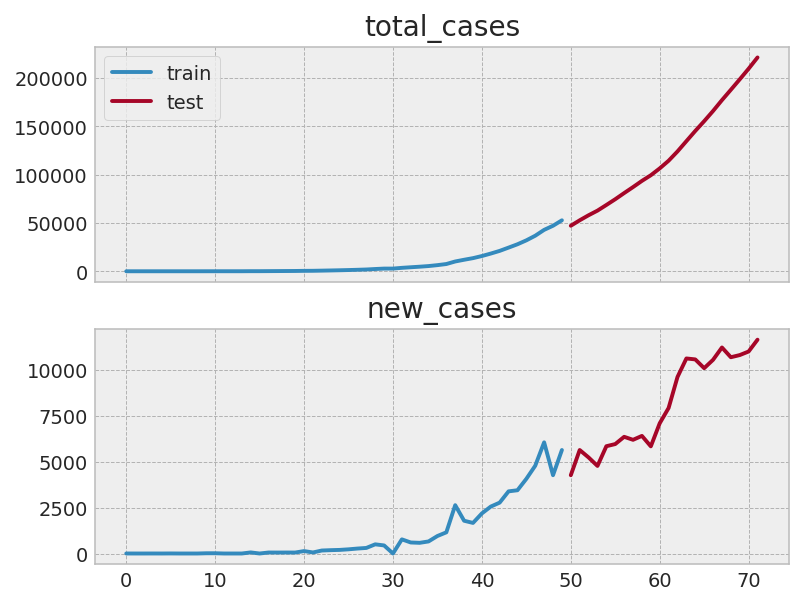

In [76]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex="all")
fig.set_dpi(140)
train_size, test_size = df_train.shape[0], df_test.shape[0]
ax1.plot(list(range(train_size)), df_train["total_cases"], label="train")
ax2.plot(list(range(train_size)), df_train["new_cases"], label="test")
ax1.plot(list(range(train_size, train_size + test_size)), df_test["total_cases"], label="test")
ax2.plot(list(range(train_size, train_size + test_size)), df_test["new_cases"], label="test")
ax1.set_title("total_cases")
ax2.set_title("new_cases")
ax1.legend()
plt.show()

## 2.a Линейная регрессия в модели экспоненцального роста

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

Если $y = exp(w_1x+w_0)$, значит $ln(y) = w_1x+w_0$ В таком случае, обучив линейную регрессию предсказывать натуральный логарифм числа заболевших, у нас получится делать предсказания экспоненциального роста числа заболевших

In [77]:
X_train = np.array(range(1, train_size + 1))
X_test = np.array(range(train_size, train_size + test_size))
y_train_total = df_train["total_cases"]
y_train_new = df_train["new_cases"]
y_test_total = df_test["total_cases"]
y_test_new = df_test["new_cases"]

In [78]:
model_lr_total = LinearRegression()
model_lr_total.fit(X_train.reshape(-1, 1), np.log(y_train_total))
print(f"ln(y)={model_lr_total.coef_[0]:.2}x+{model_lr_total.intercept_:.2}")

ln(y)=0.21x+0.98


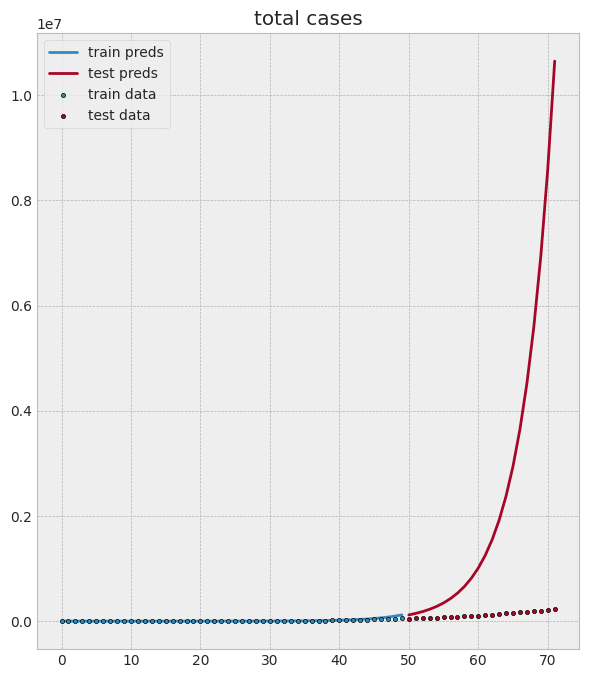

In [79]:
y_tot_train_preds = np.exp(model_lr_total.predict(X_train.reshape(-1, 1)))
y_tot_test_preds = np.exp(model_lr_total.predict(X_test.reshape(-1, 1)))
plt.figure(figsize=(7, 8))

# predictions
plt.plot(list(range(train_size)), y_tot_train_preds, label='train preds')
plt.plot(list(range(train_size, train_size + test_size)), y_tot_test_preds, label='test preds')
# real data
plt.scatter(list(range(train_size)), y_train_total,
            marker='.', edgecolors='k',
            label='train data', zorder=2)
plt.scatter(list(range(train_size, train_size + test_size)), y_test_total,
            marker='.', edgecolors='k',
            label='test data', zorder=2)

plt.title('total cases')
plt.legend()
plt.show()

## 2.b Апостариорное распределение параметров

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [80]:
VAR_0 = 3


def bayes_upd(mu, sigma, X, y, var):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / var) * (X.T @ X))
    mu_n = sigma_n @ (np.linalg.inv(sigma) @ mu + (1 / var) * (X.T @ y))
    return mu_n, sigma_n


def nth_mu_sigma(X, y, var):
    mu_0 = np.vstack(np.zeros(X.shape[1]))
    sigma_0 = VAR_0 * np.identity(X.shape[1])
    mu_n, sigma_n = bayes_upd(mu_0, sigma_0, X, y, var)
    return mu_n, sigma_n


def print_mat(mat):
    '''
    Function to print matrices
    '''
    for row_ind in range(len(mat)):
        print("\t| ", end="")
        print(*[round(x, 8) for x in mat[row_ind]], sep=" \t ", end="\t|\n")


var_est = (np.std(np.log(y_train_total) - np.log(y_tot_train_preds))) ** 2
print(f"var = {var_est:.6f}")

X_tr = np.stack([np.ones(train_size), X_train], axis=-1)
mu, sigma = nth_mu_sigma(X_tr, np.log(y_train_total.to_numpy()).reshape(-1, 1), var_est)
print("mu =")
print_mat(mu)
print("sigma =")
print_mat(sigma)

var = 0.202401
mu =
	| 0.97393074	|
	| 0.2142659	|
sigma =
	| 0.01659536 	 -0.00049293	|
	| -0.00049293 	 1.936e-05	|


## 2.c Сэмплирование экспонент

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

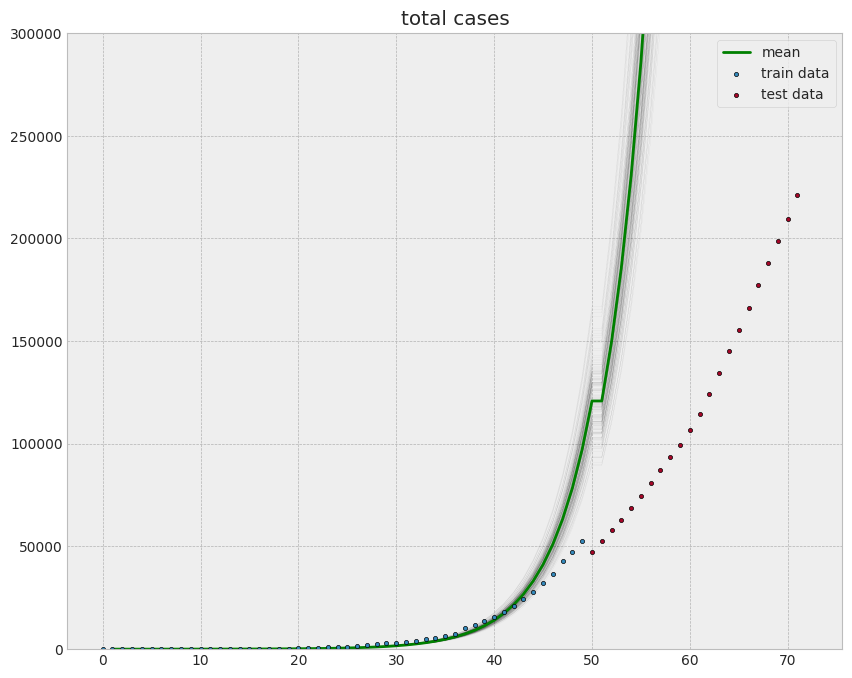

In [95]:
def plot_n_exp_curves(mu, sigma, n=25):
    plt.figure(figsize=(10, 8))

    curves = []  # for statistics
    samples = np.random.multivariate_normal(mu.flatten(), sigma, n)
    for sample in samples:
        plt.plot(dates, np.exp(X_mat_all @ sample),
                 'k', alpha=0.3, lw=0.05)
        curves.append(np.exp(X_mat_all @ sample))

    plt.plot(dates, np.mean(curves, axis=0),
             color='green', lw=2,
             label='mean')
    plt.scatter(list(range(train_size)), y_train_total,
                marker='.', edgecolors='k',
                label='train data', zorder=2)
    plt.scatter(list(range(train_size, train_size + test_size)), y_test_total,
                marker='.', edgecolors='k',
                label='test data', zorder=2)

    # plt.xlim(datetime.date(2020, 4, 1), datetime.date(2020, 5, 15))
    plt.ylim(0, 3e5)

    plt.title('total cases')
    plt.legend()


X_all = np.concatenate((X_train, X_test))
X_mat_all = np.stack([np.ones(X_all.shape[0]), X_all], axis=-1)
dates = list(range(1,train_size+test_size+1))

plot_n_exp_curves(mu, sigma, n=200)
# dates

## 3. Сигмоидальная функция

-------------------
Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:


In [100]:
y_new_train, y_new_test = df_train.new_cases.values + 1, df_test.new_cases.values +1

In [102]:
lr_new_cases = LinearRegression()
lr_new_cases.fit(np.stack([X_train, X_train ** 2], axis=-1), np.log(y_new_train))
print(lr_new_cases.coef_)
y_new_train_preds = np.exp(lr_new_cases.predict(np.stack([X_train, X_train ** 2], axis=-1)))
var_new_est = (np.std(np.log(y_new_train) - np.log(y_new_train_preds))) ** 2
print(f"var = {var_new_est:.6f}")
X_new = np.stack([np.ones(train_size), X_train, X_train ** 2], axis=-1)
mu_new, sigma_new = nth_mu_sigma(X_new, np.log(y_new_train).reshape(-1, 1), var_new_est)
print("mu =")
print_mat(mu_new)
print("sigma =")
print_mat(sigma_new)

[ 0.24283077 -0.00091649]
var = 1.491025
mu =
	| -0.79396612	|
	| 0.23654268	|
	| -0.00081237	|
sigma =
	| 0.26516676 	 -0.02099598 	 0.00034644	|
	| -0.02099598 	 0.00221841 	 -4.119e-05	|
	| 0.00034644 	 -4.119e-05 	 8.2e-07	|


### Задание 3.C

Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

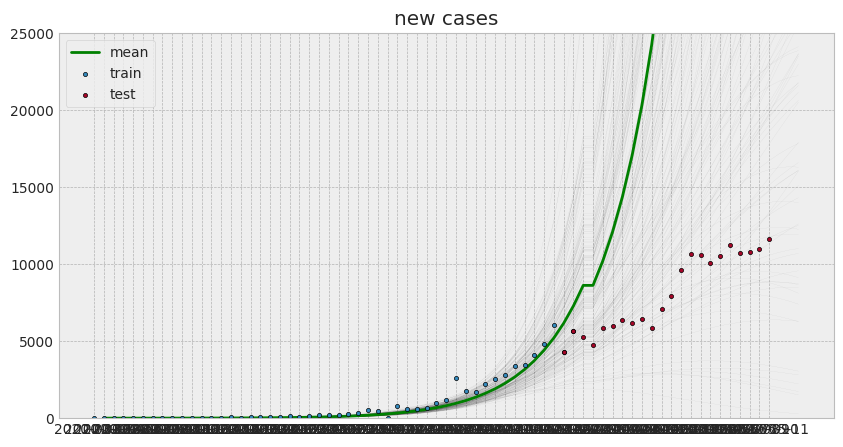

In [107]:
def plot_new_cases_curves(mu, sigma, n=25):
    plt.figure(figsize=(10, 5))

    curves = []  # for statistics
    samples = np.random.multivariate_normal(mu.flatten(), sigma, n)
    for sample in samples:
        plt.plot(dates, np.exp(X_new_all @ sample),
                 'k', alpha=0.3, lw=0.05)
        curves.append(np.exp(X_new_all @ sample))
    # mean
    plt.plot(dates, np.mean(curves, axis=0),
             color='green', lw=2,
             label='mean')
    # data
    plt.scatter(df_train.date, y_new_train,
                marker='.', edgecolors='k',
                label='train', zorder=2)
    plt.scatter(df_test.date, y_new_test,
                marker='.', edgecolors='k',
                label='test', zorder=2)

    # plt.xlim(datetime.date(2020, 4, 1), datetime.date(2020, 5, 15))
    plt.ylim(0, 2.5e4)

    plt.title('new cases')
    plt.legend()


X_new_all = np.stack([np.ones(X_all.shape[0]), X_all, X_all ** 2], axis=-1)
plot_new_cases_curves(mu_new, sigma_new, n=200)